## Bebés
Para resolver este problema se estimó primero el número de bebés de 0 a 6 meses en el municipio y después por AGEB siguiendo la distribución previa de la población.

Primero se estimó el número de nacimientos en los últimos 6 meses en el municipio; bajo la suposición de que muy pocos bebés llegan de otros municipios o se van en sus primeros meses de vida, se usó esta estimación como el total de bebés que habitan en la actualidad en Toluca. Usar simplemente la tasa de natilidad no sería muy efectivo para predecir por mes porque los nacimientos varían durante el año y posiblemente sigan patrones estacionales por lo que se trató el número de nacimientos por mes como una serie de tiempo y se predijo con un modelo ARIMA, que han sido usados para predecir poblaciones humanas(Hyndman & Booth, 2008; Alho, 1990). Se obtuvieron los datos de nacimientos en el municipio de los últimos 9 años a través del [INEGI](https://www.inegi.org.mx/sistemas/olap/Proyectos/bd/continuas/natalidad/nacimientos.asp).

Tras obtener esta predicción se predice el número de bebés por AGEB suponiendo que no ha habido cambios drásticos en las consentraciones de población por zona. Esta suposición podría afectar la estimación pues los datos usados son del censo del 2010 del [INEGI](https://www.inegi.org.mx/programas/ccpv/2010/default.html#Datos_abiertos). Sin embargo, podría mejorarse después, modificando el porcentaje de población por zona tomando en cuenta datos como la construcción o derrumbe de viviendas y la densidad de población por AGEB.

A continuación se muestra paso a paso la metodología que se siguió.

Primero se obtienen los datos de nacimientos en Toluca en años previos.

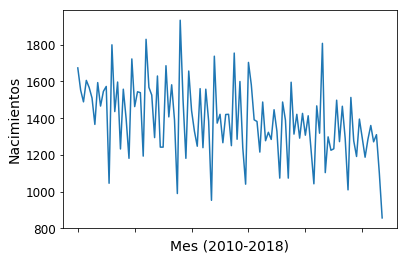

In [25]:
import matplotlib
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from tabulate import tabulate
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

#Graficas
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'G'

#Nacimientos en Toluca por mes de 2010-2018, FUENTE: INEGI
months = list(range(3,15))
df_list = [pd.read_csv('datos/n'+str(i)+'.csv',thousands=r',',header=4,usecols=months,dtype=np.float64,nrows=122) for i in range(2010,2019)]
for i in range(2010,2019):
	df_list[i-2010]=df_list[i-2010].add_suffix('_'+str(i))
series_births = df_list[0].iloc[121]
for year in df_list[1:]:
	series_births = series_births.append(year.iloc[121])
s_size = series_births.size
ax = series_births.plot()
ax.set_xlabel('Mes (2010-2018)')
ax.set_ylabel('Nacimientos')
matplotlib.pyplot.show()


Se busca estacionalidad anual.

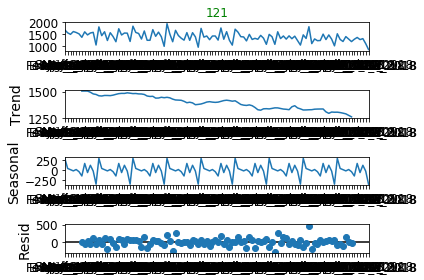

In [18]:
decomposition = sm.tsa.seasonal_decompose(series_births, model='additive',period=12)
fig = decomposition.plot()
matplotlib.pyplot.show()

Los modelos ARIMA han sido usados anteriormente para predecir poblaciones, en este caso se usa SARIMA por la estacionalidad que parece existir. Se encuentran los parámetros de este modelo automáticamente.

In [19]:
print(auto_arima(series_births, seasonal=True, m=12,max_p=7, max_d=5,max_q=7, max_P=4, max_D=4,max_Q=4).summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  108
Model:             SARIMAX(3, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -672.371
Date:                            Sat, 01 Feb 2020   AIC                           1360.741
Time:                                    11:53:25   BIC                           1382.124
Sample:                                         0   HQIC                          1369.410
                                            - 108                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0408      0.141     -0.289      0.773      -0.317       0.236
ar.L1         -0.4183      0.130   

Graficamos la predicción del modelo y la real del año 2018

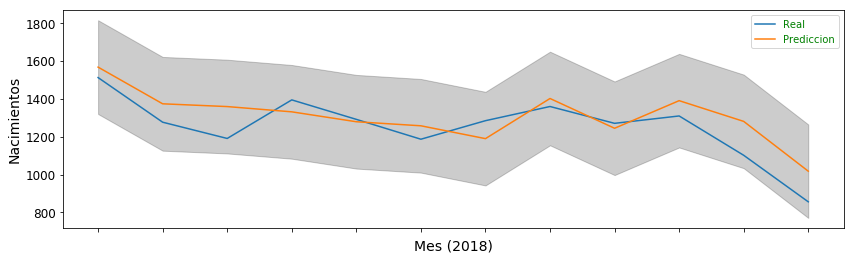

In [20]:
#Parametros de auto_arima
arima_model = SARIMAX(series_births, order = (3,1,1), seasonal_order = (1,0,1,12))
arima_result = arima_model.fit()
#Train 2010-2017 Test 2018
pred = arima_result.get_prediction(start=s_size-12, dynamic=False)
pred_ci = pred.conf_int()

ax = series_births.iloc[s_size-12:].plot(label='Real')

pred.predicted_mean.plot(ax=ax, label='Prediccion', figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Mes (2018)')
ax.set_ylabel('Nacimientos')
matplotlib.pyplot.legend()
matplotlib.pyplot.show()

Calculamos la efectividad del modelo en el año 2018.

In [22]:
#Performance del modelo
forecasted = pred.predicted_mean
truth = series_births[s_size-12:]
#mse = mean_squared_error(truth,forecasted)
mae = mean_absolute_error(truth,forecasted)
mpe = np.mean(np.abs((truth - forecasted) / truth)) * 100
print('Mean Absolute Error: {}'.format(round(mae, 2)))
print('Mean Percentage Error: {}%'.format(round(mpe, 2)))

Mean Absolute Error: 87.79
Mean Percentage Error: 7.57%


Se predicen los nacimiento en Toluca de los últimos 6 meses.

In [23]:
#Predicciones 2019
pred_2019 = arima_result.predict(start=s_size, end=s_size+13, dynamic=False)
pred_today = sum(pred_2019[-6:]) #ultimos seis meses
print('Bebes en Toluca hoy: {}'.format(round(pred_today)))

Bebes en Toluca hoy: 7409


# Resultado
Finalmente se determina el número de bebés por AGEB siguiendo la proporción de bebés (0 a 2 años) por zona del censo de 2010.

In [26]:
#Proporciones por AGEB
#Suponiendo que la la relacion entre AGEB y municipio no cambia
#FUENTE: INEGI
babies_mexico = pd.read_csv('datos/ageb_cpv2010.csv',index_col='nom_mun',usecols=['nom_mun','nom_loc','ageb','p_0a2'])
babies_mza = babies_mexico.loc[['Toluca']] #Resultados por manzana
babies_ageb = babies_mza[babies_mza['nom_loc']=='Total AGEB urbana']
babies_toluca = 0
pred_ageb = []
for ageb in babies_ageb['p_0a2']:
	if(ageb!='*'):
		babies_toluca+=int(ageb)
for index, row in babies_ageb.iterrows():
	if(row['p_0a2']=='*'):
		pop = 0
	else:
		pop = int(row['p_0a2'])
	pred_ageb.append([row['ageb'],round((pop/babies_toluca)*pred_today)])
#Resultado final
print(tabulate(pred_ageb,headers=['AGEB','Bebes de 0 a 6 meses']))

AGEB      Bebes de 0 a 6 meses
------  ----------------------
0307                        28
0330                        32
0345                        20
035A                        50
0379                        46
0383                        20
0398                        14
0400                        18
0415                        15
042A                        19
0434                        18
0449                        25
0453                        10
0468                        19
0472                         4
0487                        20
0491                        16
0504                        23
0519                         6
0523                        17
0538                         9
0542                        11
0557                        22
0561                        43
0576                        16
0580                         4
0595                         8
0608                        19
0631                        18
0646                        50
0699    

# Fuentes
Alho, J. M. (1990). Stochastic methods in population forecasting. International Journal of forecasting, 6(4), 521-530.
Hyndman, R. J., & Booth, H. (2008).

Stochastic population forecasts using functional data models for mortality, fertility and migration. International Journal of Forecasting, 24(3), 323-342.

INEGI, C. D. P. Y. V. (2010). Principales resultados por localidad.